# SNV Frequency Spectrum 

**Date**: 2019-10-07, modified 2019-01-21, modified 2021-04-21       
**Author**: Katarina Braun 

## Overview
This notebook plots SNV frequency spectrums.  

I will compare iSNV frequency spectrums before and after transmission as well as in virus groups. 

**From Moncla et al, 2019, bioRxiv (https://doi.org/10.1101/683151):**  
"Purifying selection removes new variants from the population, generating an excess of low-freq variants, while positive selection promotes accumulation of high-frequency polymorphisms. Exponential population expansion also causes excess low-frequency variation; however, while selection disproportionately affects nonsynonymous variants, demographic factors affect synonymous and nonsynonymous variants equally."

I'll look for evidence of postive vs purifying selection following the transmission event. And, at least for now, I'll look across the entire genome. I could theoretically plot these for each gene segment, but I don't know if I have enough SNP calls to make anything out of that. 

Y = proportion of SNVs
X = within-host SNV frequency bins: 1-10%, 10-20%, 20-30%, 30-40%, 40-50%

I will also try to derive the "neutral expectation" -- that is the distribution of SNPs expected for a given population assuming that the population is not under selection and is at some sort of steady-state equilibrium. 

For the neutral expectation, Trevor Bedford suggests this will follow a 1/x distribution. I can then just integrate over a 1/x distribution between each bin size (0.01 to 0.1, 0.1 to 0.2, etc...). Then I'll calculate the proportion of the total that fall into each bin. Dr. Louise Moncal (cited above) already prepared a notebook to do this: `neutral-expectation.ipynb`, which I am going to utilize here. 
    
### Note about HA numbering: 
For H7N9, I used H7 numbering. This numbering scheme matches the numbering scheme on Nextstrain (https://nextstrain.org/).  
For H1N1pdm, I use H1 numbering. Again, this numbering scheme matches the numbering scheme on Nextstrain. For clarity, I start counting amino acids at nucleotide #51, AA #18 (D). 

## Input: 

- annotated VCF files that Sniffles outputs: `H7N9/data_derived/iSNVs/vcfs-intersection/*`
 

## Output: 
- `H7N9/figures/SFS/*`

## import modules and dependecies 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from itertools import cycle, islice
import random 
from pylab import *
from matplotlib.ticker import StrMethodFormatter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import csv
import sys, subprocess, glob, os, shutil, re, importlib, Bio
from subprocess import call
from Bio import SeqIO
from scipy import stats
from scipy.integrate import quad
import seaborn as sns
import os
import seaborn as sns; sns.set()
from matplotlib import pyplot
from functools import reduce
import matplotlib as mpl
from matplotlib import gridspec
import itertools
import pysam
import matplotlib.patches as mpatches
import random 
from pylab import *
from matplotlib.font_manager import FontProperties 
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
from matplotlib import gridspec

## Add in neutral expectation as a dashed line

The neutral expectation code is from Dr. Louise Moncla (https://github.com/lmoncla). 

The expectation for the proportion of variants in each frequency bin is given by a 1/x distribution. I will integrate the area under the curve for a 1/x distribution between each interval and plot this expected value.

In [2]:
# define functions 

def integrate_over_bins(lower_bound,upper_bound):
    # generate lambda function for 1/x
    f= lambda x:(1/x)

    # integrate between bins 
    integral = quad(f, lower_bound, upper_bound)[0]
    return(integral)

def return_area_under_curve(bins):

    total_area_under_curve = 0
    integrals = []
    
    for i in range(len(bins)-1):
        lower_bound = bins[i]
        upper_bound = bins[i+1]
        integral = integrate_over_bins(lower_bound,upper_bound)
        integrals.append(integral)
        
    total_area_under_curve = np.asarray(integrals).sum()
    return(total_area_under_curve, integrals)

def return_neutral_expectation(total_area_under_curve, integrals):
    proportions = []
    for i in integrals: 
        proportion = i/total_area_under_curve
        proportions.append(proportion)
        
    return(proportions)

In [3]:
# predict neutral expectations for 10 bins 
bins = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99]
total_area_under_curve, integrals = return_area_under_curve(bins)
proportions = return_neutral_expectation(total_area_under_curve, integrals)
neutral_df = pd.DataFrame({"bin":["1-10%","10-20%","20-30%","30-40%","40-50%","50-60%","60-70%","70-80%","80-90%","90-99%"],"expected":proportions})
neutral_df.set_index('bin', inplace=True)
neutral_df.rename(columns={'expected':'neutral expectation'}, inplace=True)

## Defines functions 

In [4]:
def plot_SFS(ferret,t1,t2,t3,t4):
    i = pd.read_csv('../data_derived/iSNVs-over-time/'+ ferret + '.csv', sep='\t')
    # modify the dataframes to retain only SNP and frequency 
    # drop any rows with SNPs between 99 and 100% frequency
    i = i.drop(['SNP', 'Unnamed: 0'], 1)
    if t1 is None: 
        print("t1 = None")
    else:
        i1 = i[[t1]]
        SFS_1 = i1.apply(pd.Series.value_counts, bins=[.010,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99])
        SFS_1 = SFS_1.sort_index(ascending=True)
        t1_sum = SFS_1[t1].sum()
        SFS_1['proportion_of_iSNVs_1'] = SFS_1[t1] / t1_sum
        SFS_1 = SFS_1[['proportion_of_iSNVs_1']]
        SFS_1 = SFS_1.rename(columns={'proportion_of_iSNVs_1':t1})

    if t2 is None: 
        print("t2 = None")
    else:
        i2 = i[[t2]]
        SFS_2 = i2.apply(pd.Series.value_counts, bins=[.010,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99])
        SFS_2 = SFS_2.sort_index(ascending=True)
        t2_sum = SFS_2[t2].sum()
        SFS_2['proportion_of_iSNVs_2'] = SFS_2[t2] / t2_sum
        SFS_2 = SFS_2[['proportion_of_iSNVs_2']]
        SFS_2 = SFS_2.rename(columns={'proportion_of_iSNVs_2':t2})
        t = pd.concat([SFS_1, SFS_2],axis=1)

    if t3 is None: 
        print("t3 = None")
    else:
        i3 = i[[t3]]
        SFS_3 = i3.apply(pd.Series.value_counts, bins=[.010,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99])
        SFS_3 = SFS_3.sort_index(ascending=True)
        t3_sum = SFS_3[t3].sum()
        SFS_3['proportion_of_iSNVs_3'] = SFS_3[t3] / t3_sum
        SFS_3 = SFS_3[['proportion_of_iSNVs_3']]
        SFS_3 = SFS_3.rename(columns={'proportion_of_iSNVs_3':t3})
        t = pd.concat([t, SFS_3],axis=1)

    if t4 is None: 
        print("t4 = None")
    else:
        i4 = i[[t4]]
        SFS_4 = i4.apply(pd.Series.value_counts, bins=[.010,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99])
        SFS_4 = SFS_4.sort_index(ascending=True)#     
        t4_sum = SFS_4[t4].sum()
        SFS_4['proportion_of_iSNVs_4'] = SFS_4[t4] / t4_sum
        SFS_4 = SFS_4[['proportion_of_iSNVs_4']]
        SFS_4 = SFS_4.rename(columns={'proportion_of_iSNVs_4':t4})
        t = pd.concat([t, SFS_4],axis=1)

    t['bins'] = ['1-10%','10-20%','20-30%','30-40%','40-50%','50-60%','60-70%','70-80%','80-90%','90-99%']
    final = t.set_index('bins')
    # final = pd.concat([t,neutral_df],axis=1)

    final.to_csv('../data_derived/SFS/' + ferret + '_SFS.csv', sep='\t')

    # generate a figure with sub-plots (one for each gene segment)
    fig = plt.figure(figsize=(6,6), facecolor='w')
    plt.style.use('default')
    mpl.rc('font', family='Arial')
    gs = gridspec.GridSpec(2,5)

    ax1 = fig.add_subplot(gs[0,0:3]) #pair1

    # get right of top and right frame of each subplot
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(True)
    ax1.spines['left'].set_visible(True)

    # set fontsize of axes 
    ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
    ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)

    final.plot(kind='bar', grid=False, figsize=(12,8), width=0.8, alpha=1, ax=ax1)
    neutral_df.plot(kind='bar', grid=False, color='lightgrey', figsize=(12,8), width=0.8, alpha=0.5, ax=ax1)

    ax1.set_title(ferret, fontname='Arial', fontsize=14)
    ax1.set_facecolor('white')
    for tick in ax1.get_xticklabels():
        tick.set_fontname("Arial")
    for tick in ax1.get_yticklabels():
        tick.set_fontname("Arial")
    ax1.set_ylim(0,1.0)
    ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax1.set_ylabel('proportion of SNVs', fontname='Arial', fontsize=12)
    ax1.set_xlabel('within-host SNV frequency (%)', fontname='Arial', fontsize=12)
    ax1.set_xticklabels(['1-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-99%'], fontname='Arial', fontsize=10, minor=False, rotation=45)
    ax1.legend(loc=0, frameon=False, fontsize=10, ncol=1)

    plt.savefig('../figures/SFS/' + ferret + '_' + 'SFS.pdf', dpi=300)

#

t4 = None
t3 = None
t4 = None
t4 = None
t4 = None
t4 = None
t4 = None
t3 = None
t4 = None
t4 = None
t3 = None
t4 = None
t4 = None
t3 = None
t4 = None
t4 = None
t4 = None


/Users/katbraun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


t3 = None
t4 = None
t3 = None
t4 = None
t4 = None
t4 = None
t4 = None
t4 = None
t4 = None


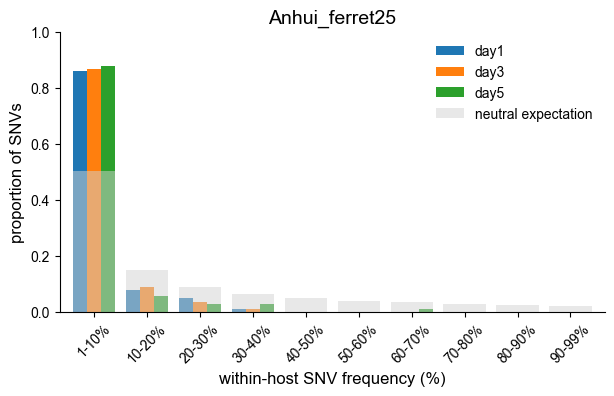

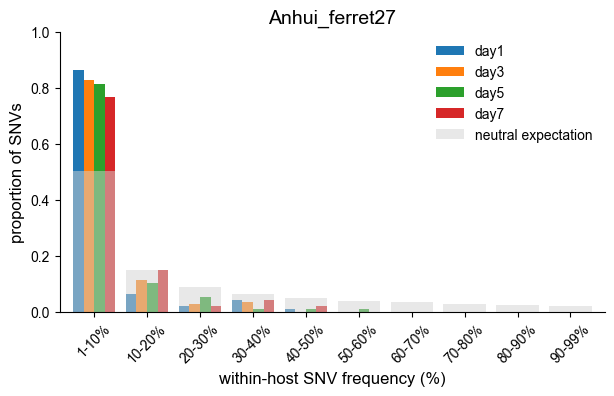

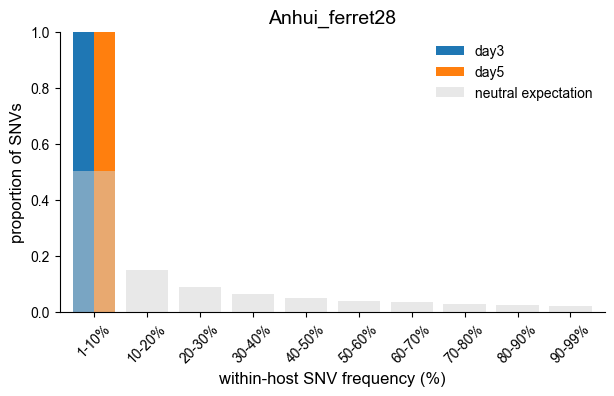

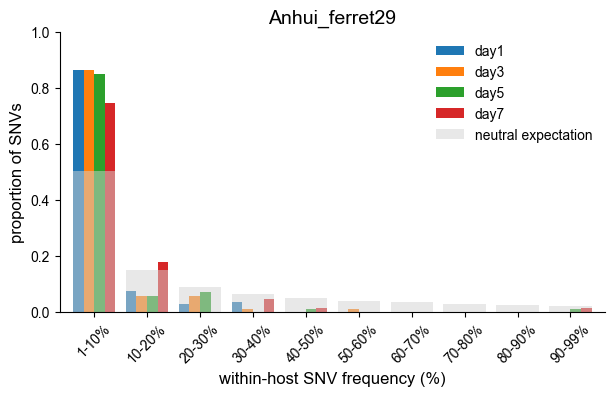

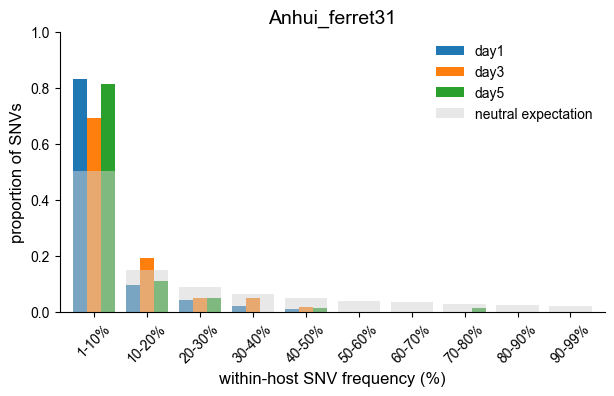

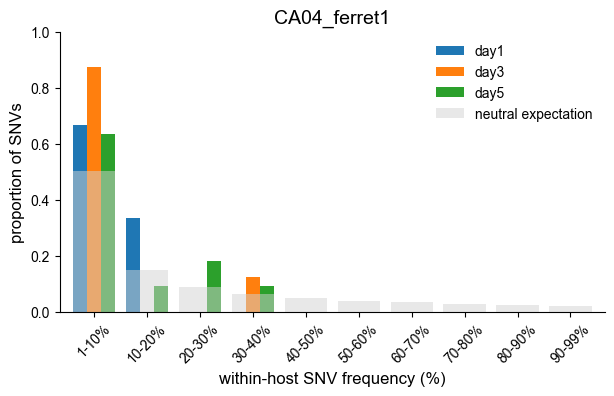

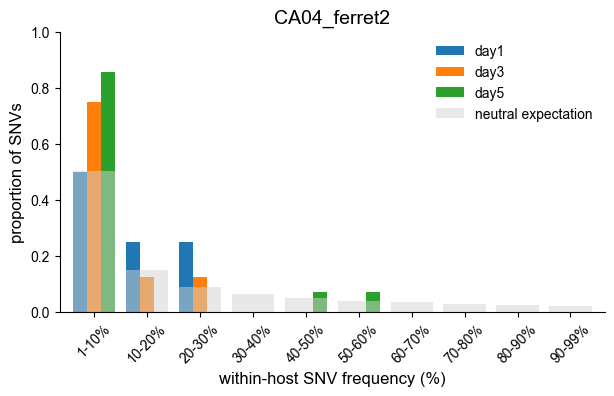

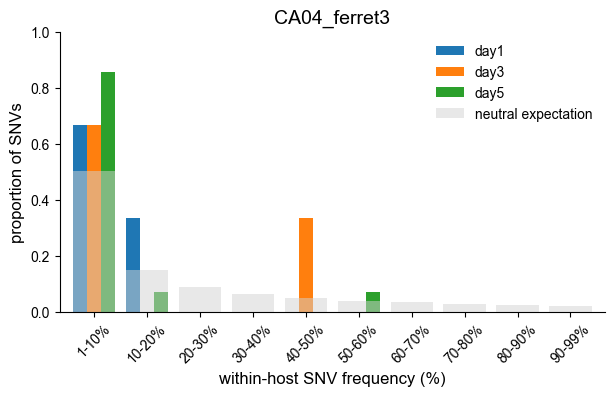

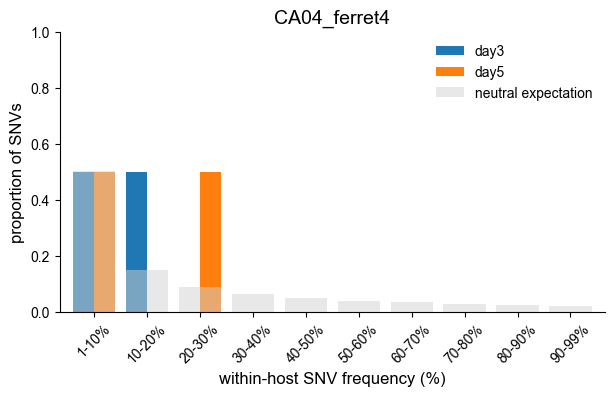

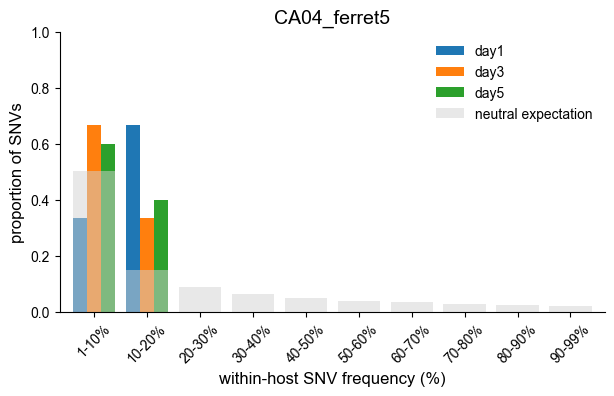

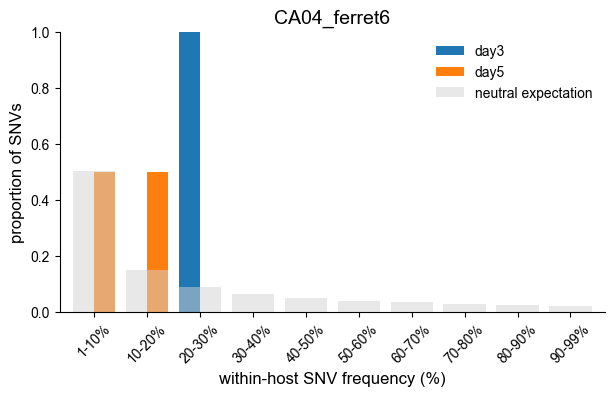

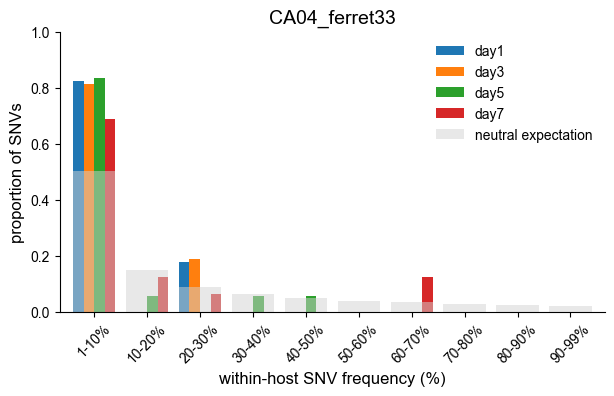

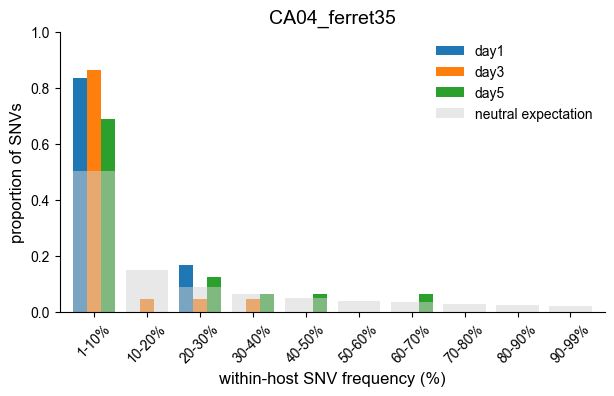

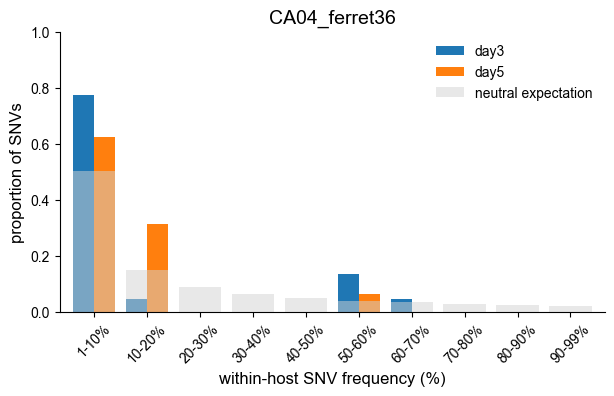

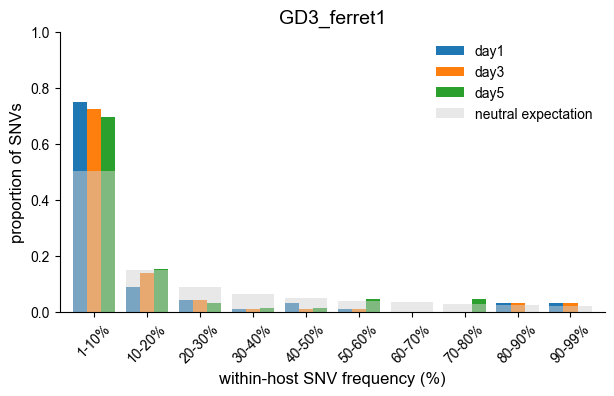

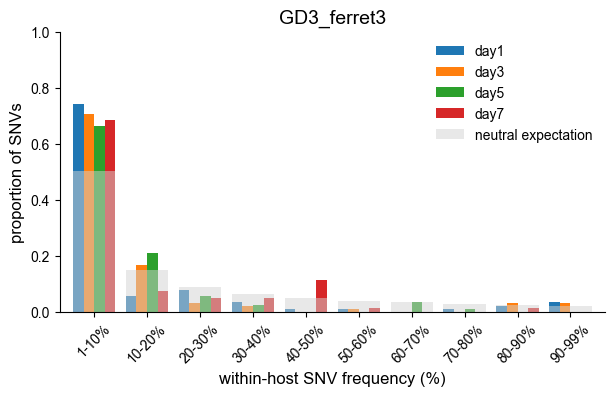

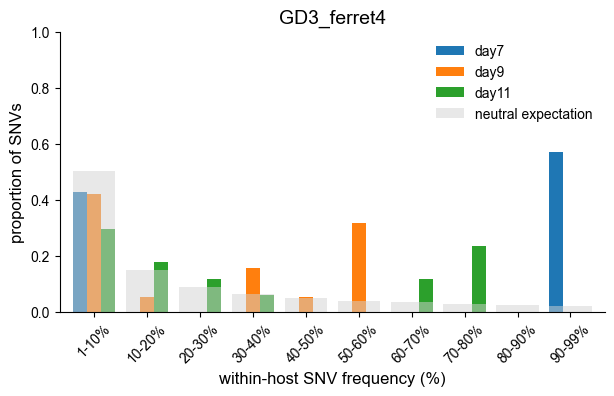

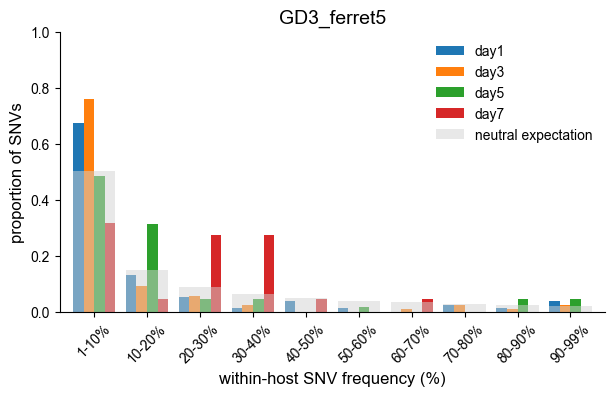

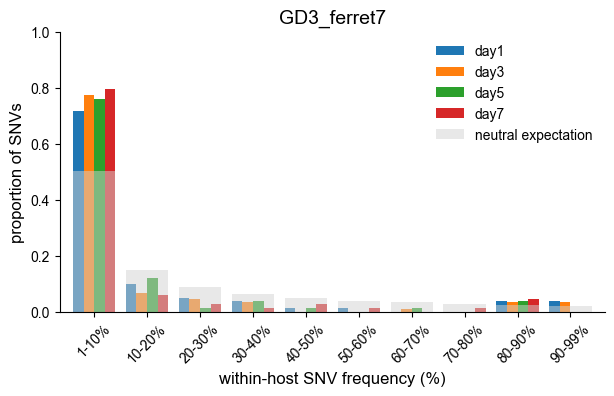

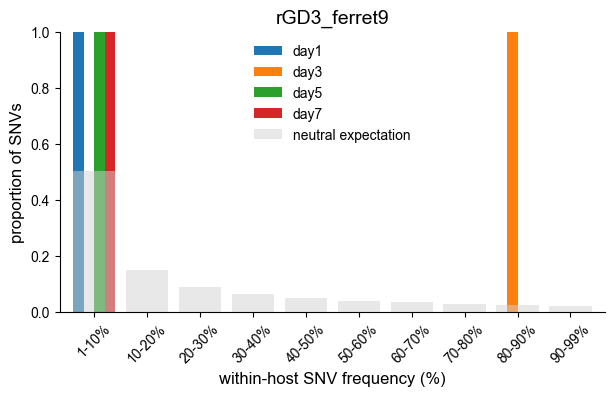

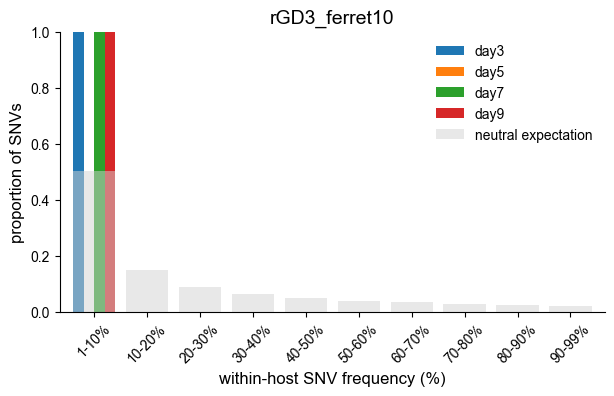

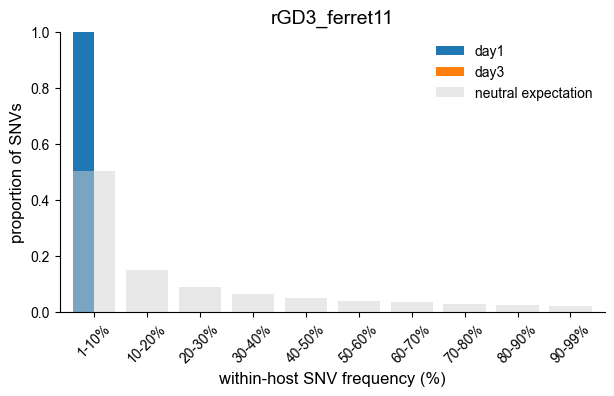

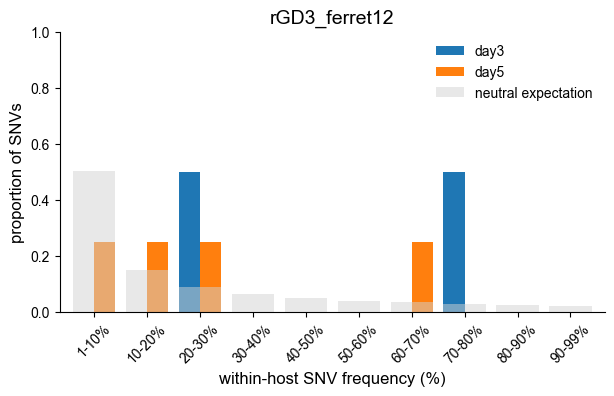

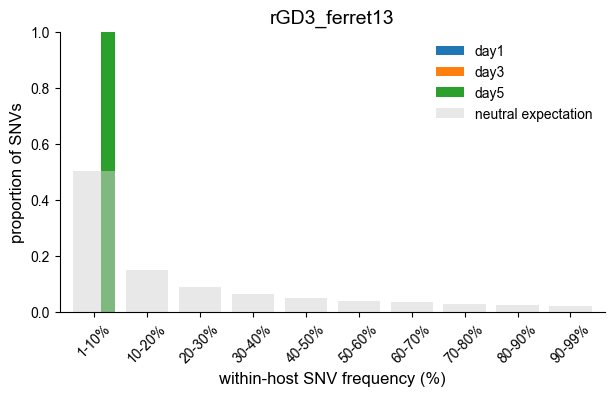

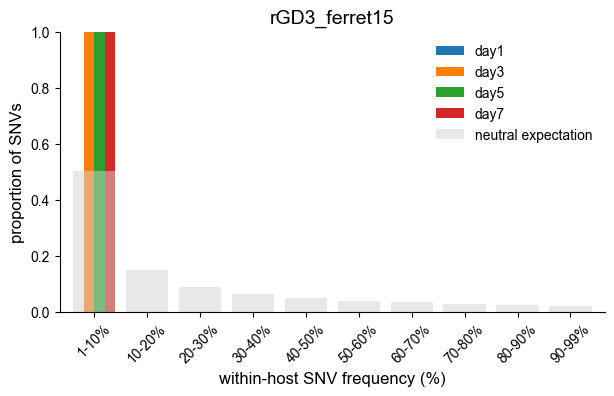

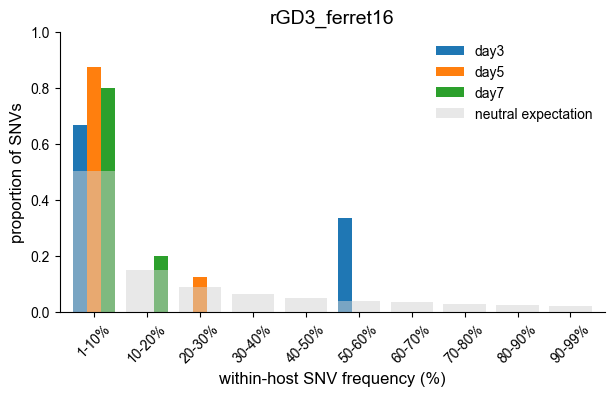

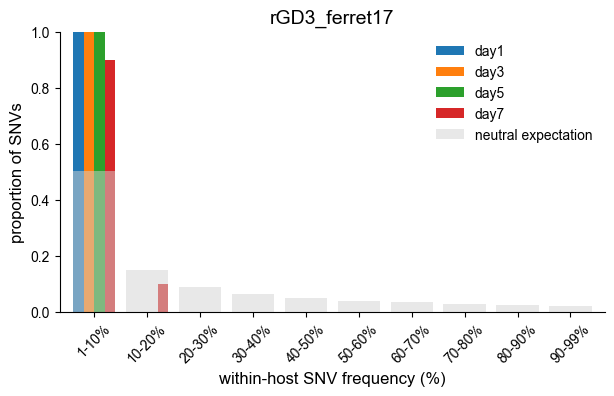

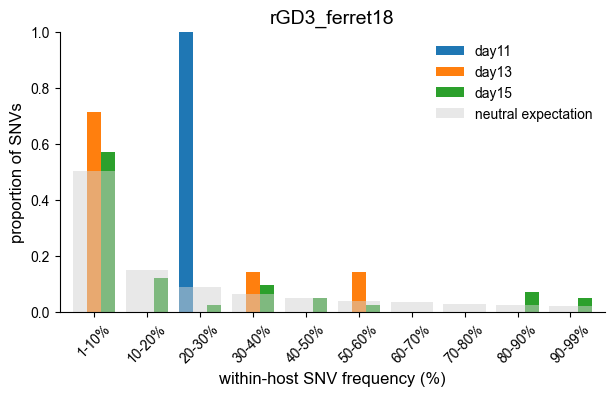

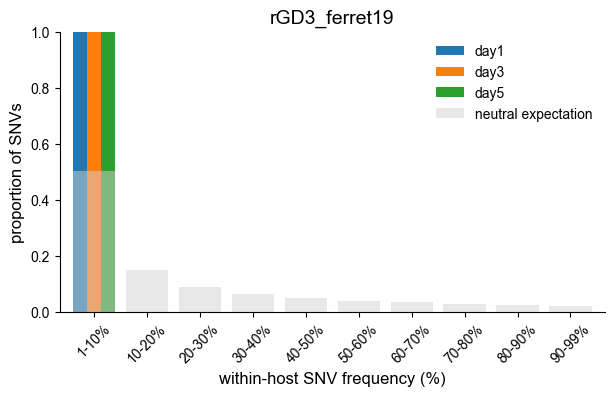

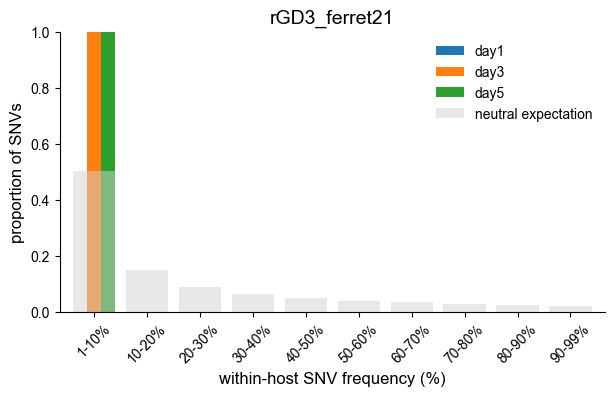

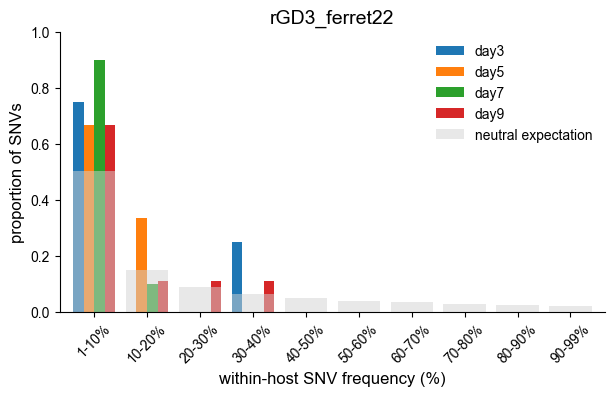

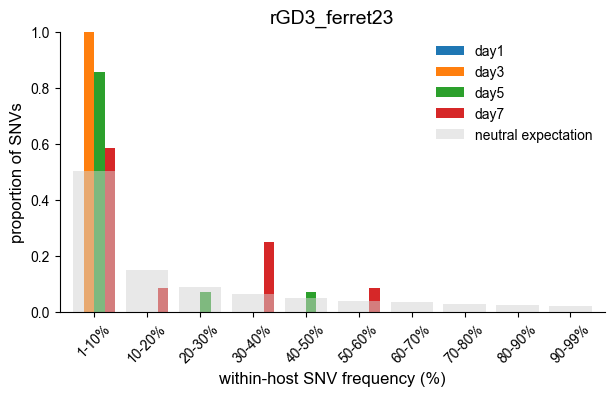

In [6]:
# plot_SFS(ferret,t1,t2,t3,t4)

plot_SFS('Anhui_ferret25','day1','day3','day5',None)
plot_SFS('Anhui_ferret27','day1','day3','day5', 'day7')
plot_SFS('Anhui_ferret28','day3','day5',None, None)
plot_SFS('Anhui_ferret29','day1','day3','day5', 'day7')
plot_SFS('Anhui_ferret31','day1','day3','day5',None)
plot_SFS('CA04_ferret1','day1','day3','day5',None)
plot_SFS('CA04_ferret2','day1','day3','day5',None)
plot_SFS('CA04_ferret3','day1','day3','day5',None)
plot_SFS('CA04_ferret4','day3','day5',None,None)
plot_SFS('CA04_ferret5','day1','day3','day5',None)
plot_SFS('CA04_ferret6','day3','day5',None,None)
plot_SFS('CA04_ferret33','day1','day3','day5', 'day7')
plot_SFS('CA04_ferret35','day1','day3','day5', None)
plot_SFS('CA04_ferret36','day3','day5', None, None)
plot_SFS('GD3_ferret1','day1','day3','day5', None)
plot_SFS('GD3_ferret3','day1','day3','day5', 'day7')
plot_SFS('GD3_ferret4','day7','day9','day11', None)
plot_SFS('GD3_ferret5','day1','day3','day5', 'day7')
plot_SFS('GD3_ferret7','day1','day3','day5', 'day7')
plot_SFS('rGD3_ferret9','day1','day3','day5', 'day7')
plot_SFS('rGD3_ferret10','day3','day5','day7', 'day9')
plot_SFS('rGD3_ferret11','day1','day3',None, None)
plot_SFS('rGD3_ferret12','day3','day5',None, None)
plot_SFS('rGD3_ferret13','day1','day3','day5', None)
plot_SFS('rGD3_ferret15','day1','day3','day5', 'day7')
plot_SFS('rGD3_ferret16','day3','day5','day7', None)
plot_SFS('rGD3_ferret17','day1','day3','day5', 'day7')
plot_SFS('rGD3_ferret18','day11','day13','day15', None)
plot_SFS('rGD3_ferret19','day1','day3','day5', None)
plot_SFS('rGD3_ferret21','day1','day3','day5', None)
plot_SFS('rGD3_ferret22','day3','day5','day7', 'day9')
plot_SFS('rGD3_ferret23','day1','day3','day5', 'day7')

#

In [7]:
# repeat above but average across virus groups 
anhui_ferret25 = pd.read_csv('../data_derived/SFS/Anhui_ferret25_SFS.csv', sep='\t')
anhui_ferret25 = anhui_ferret25.set_index('bins')
anhui_ferret25['avgf'] = anhui_ferret25.mean(axis=1)
anhui_ferret25 = anhui_ferret25[['avgf']]

anhui_ferret27 = pd.read_csv('../data_derived/SFS/Anhui_ferret27_SFS.csv', sep='\t')
anhui_ferret27 = anhui_ferret27.set_index('bins')
anhui_ferret27['avgf'] = anhui_ferret27.mean(axis=1)
anhui_ferret27 = anhui_ferret27[['avgf']]

anhui_ferret28 = pd.read_csv('../data_derived/SFS/Anhui_ferret28_SFS.csv', sep='\t')
anhui_ferret28 = anhui_ferret28.set_index('bins')
anhui_ferret28['avgf'] = anhui_ferret28.mean(axis=1)
anhui_ferret28 = anhui_ferret28[['avgf']]

anhui_ferret29 = pd.read_csv('../data_derived/SFS/Anhui_ferret29_SFS.csv', sep='\t')
anhui_ferret29 = anhui_ferret29.set_index('bins')
anhui_ferret29['avgf'] = anhui_ferret29.mean(axis=1)
anhui_ferret29 = anhui_ferret29[['avgf']]

anhui_ferret31 = pd.read_csv('../data_derived/SFS/Anhui_ferret31_SFS.csv', sep='\t')
anhui_ferret31 = anhui_ferret31.set_index('bins')
anhui_ferret31['avgf'] = anhui_ferret31.mean(axis=1)
anhui_ferret31 = anhui_ferret31[['avgf']]

t = pd.concat([anhui_ferret25, anhui_ferret27],axis=1)
t = pd.concat([t, anhui_ferret28],axis=1)
t = pd.concat([t, anhui_ferret29],axis=1)
anhui = pd.concat([t, anhui_ferret31],axis=1)

anhui['a-avg'] = anhui.mean(axis=1)
anhui['a-stdev'] = anhui.std(axis=1)
anhui = anhui[['a-avg', 'a-stdev']]

# anhui


In [8]:
# repeat above but average across virus groups 
CA04_ferret1 = pd.read_csv('../data_derived/SFS/CA04_ferret1_SFS.csv', sep='\t')
CA04_ferret1 = CA04_ferret1.set_index('bins')
CA04_ferret1['avgf'] = CA04_ferret1.mean(axis=1)
CA04_ferret1 = CA04_ferret1[['avgf']]

CA04_ferret2 = pd.read_csv('../data_derived/SFS/CA04_ferret2_SFS.csv', sep='\t')
CA04_ferret2 = CA04_ferret2.set_index('bins')
CA04_ferret2['avgf'] = CA04_ferret2.mean(axis=1)
CA04_ferret2 = CA04_ferret2[['avgf']]

CA04_ferret3 = pd.read_csv('../data_derived/SFS/CA04_ferret3_SFS.csv', sep='\t')
CA04_ferret3 = CA04_ferret3.set_index('bins')
CA04_ferret3['avgf'] = CA04_ferret3.mean(axis=1)
CA04_ferret3 = CA04_ferret3[['avgf']]

CA04_ferret4 = pd.read_csv('../data_derived/SFS/CA04_ferret4_SFS.csv', sep='\t')
CA04_ferret4 = CA04_ferret4.set_index('bins')
CA04_ferret4['avgf'] = CA04_ferret4.mean(axis=1)
CA04_ferret4 = CA04_ferret4[['avgf']]

CA04_ferret5 = pd.read_csv('../data_derived/SFS/CA04_ferret5_SFS.csv', sep='\t')
CA04_ferret5 = CA04_ferret5.set_index('bins')
CA04_ferret5['avgf'] = CA04_ferret5.mean(axis=1)
CA04_ferret5 = CA04_ferret5[['avgf']]

CA04_ferret6 = pd.read_csv('../data_derived/SFS/CA04_ferret6_SFS.csv', sep='\t')
CA04_ferret6 = CA04_ferret6.set_index('bins')
CA04_ferret6['avgf'] = CA04_ferret6.mean(axis=1)
CA04_ferret6 = CA04_ferret6[['avgf']]

CA04_ferret33 = pd.read_csv('../data_derived/SFS/CA04_ferret33_SFS.csv', sep='\t')
CA04_ferret33 = CA04_ferret33.set_index('bins')
CA04_ferret33['avgf'] = CA04_ferret33.mean(axis=1)
CA04_ferret33 = CA04_ferret33[['avgf']]

CA04_ferret35 = pd.read_csv('../data_derived/SFS/CA04_ferret35_SFS.csv', sep='\t')
CA04_ferret35 = CA04_ferret35.set_index('bins')
CA04_ferret35['avgf'] = CA04_ferret35.mean(axis=1)
CA04_ferret35 = CA04_ferret35[['avgf']]

CA04_ferret36 = pd.read_csv('../data_derived/SFS/CA04_ferret36_SFS.csv', sep='\t')
CA04_ferret36 = CA04_ferret36.set_index('bins')
CA04_ferret36['avgf'] = CA04_ferret36.mean(axis=1)
CA04_ferret36 = CA04_ferret36[['avgf']]

t = pd.concat([CA04_ferret33, CA04_ferret35],axis=1)
t = pd.concat([t, CA04_ferret36],axis=1)
t = pd.concat([t, CA04_ferret1],axis=1)
t = pd.concat([t, CA04_ferret2],axis=1)
t = pd.concat([t, CA04_ferret3],axis=1)
t = pd.concat([t, CA04_ferret4],axis=1)
t = pd.concat([t, CA04_ferret5],axis=1)
CA04 = pd.concat([t, CA04_ferret6],axis=1)

CA04['c-avg'] = CA04.mean(axis=1)
CA04['c-stdev'] = CA04.std(axis=1)
CA04 = CA04[['c-avg', 'c-stdev']]


In [9]:
# repeat above but average across virus groups 
GD3_ferret1 = pd.read_csv('../data_derived/SFS/GD3_ferret1_SFS.csv', sep='\t')
GD3_ferret1 = GD3_ferret1.set_index('bins')
GD3_ferret1['avgf'] = GD3_ferret1.mean(axis=1)
GD3_ferret1 = GD3_ferret1[['avgf']]

GD3_ferret3 = pd.read_csv('../data_derived/SFS/GD3_ferret3_SFS.csv', sep='\t')
GD3_ferret3 = GD3_ferret3.set_index('bins')
GD3_ferret3['avgf'] = GD3_ferret3.mean(axis=1)
GD3_ferret3 = GD3_ferret3[['avgf']]

GD3_ferret4 = pd.read_csv('../data_derived/SFS/GD3_ferret4_SFS.csv', sep='\t')
GD3_ferret4 = GD3_ferret4.set_index('bins')
GD3_ferret4['avgf'] = GD3_ferret4.mean(axis=1)
GD3_ferret4 = GD3_ferret4[['avgf']]

GD3_ferret5 = pd.read_csv('../data_derived/SFS/GD3_ferret5_SFS.csv', sep='\t')
GD3_ferret5 = GD3_ferret5.set_index('bins')
GD3_ferret5['avgf'] = GD3_ferret5.mean(axis=1)
GD3_ferret5 = GD3_ferret5[['avgf']]

GD3_ferret7 = pd.read_csv('../data_derived/SFS/GD3_ferret7_SFS.csv', sep='\t')
GD3_ferret7 = GD3_ferret7.set_index('bins')
GD3_ferret7['avgf'] = GD3_ferret7.mean(axis=1)
GD3_ferret7 = GD3_ferret7[['avgf']]

t = pd.concat([GD3_ferret1, GD3_ferret3],axis=1)
t = pd.concat([t, GD3_ferret4],axis=1)
t = pd.concat([t, GD3_ferret5],axis=1)
GD3 = pd.concat([t, GD3_ferret7],axis=1)

GD3['g-avg'] = GD3.mean(axis=1)
GD3['g-stdev'] = GD3.std(axis=1)
GD3 = GD3[['g-avg', 'g-stdev']]

# GD3

In [10]:
# repeat above but average across virus groups 
rGD3_ferret9 = pd.read_csv('../data_derived/SFS/rGD3_ferret9_SFS.csv', sep='\t')
rGD3_ferret9 = rGD3_ferret9.set_index('bins')
rGD3_ferret9['avgf'] = rGD3_ferret9.mean(axis=1)
rGD3_ferret9 = rGD3_ferret9[['avgf']]

rGD3_ferret10 = pd.read_csv('../data_derived/SFS/rGD3_ferret10_SFS.csv', sep='\t')
rGD3_ferret10 = rGD3_ferret10.set_index('bins')
rGD3_ferret10['avgf'] = rGD3_ferret10.mean(axis=1)
rGD3_ferret10 = rGD3_ferret10[['avgf']]

rGD3_ferret11 = pd.read_csv('../data_derived/SFS/rGD3_ferret11_SFS.csv', sep='\t')
rGD3_ferret11 = rGD3_ferret11.set_index('bins')
rGD3_ferret11['avgf'] = rGD3_ferret11.mean(axis=1)
rGD3_ferret11 = rGD3_ferret11[['avgf']]

rGD3_ferret12 = pd.read_csv('../data_derived/SFS/rGD3_ferret12_SFS.csv', sep='\t')
rGD3_ferret12 = rGD3_ferret12.set_index('bins')
rGD3_ferret12['avgf'] = rGD3_ferret12.mean(axis=1)
rGD3_ferret12 = rGD3_ferret12[['avgf']]

rGD3_ferret13 = pd.read_csv('../data_derived/SFS/rGD3_ferret13_SFS.csv', sep='\t')
rGD3_ferret13 = rGD3_ferret13.set_index('bins')
rGD3_ferret13['avgf'] = rGD3_ferret13.mean(axis=1)
rGD3_ferret13 = rGD3_ferret13[['avgf']]

rGD3_ferret15 = pd.read_csv('../data_derived/SFS/rGD3_ferret15_SFS.csv', sep='\t')
rGD3_ferret15 = rGD3_ferret15.set_index('bins')
rGD3_ferret15['avgf'] = rGD3_ferret15.mean(axis=1)
rGD3_ferret15 = rGD3_ferret15[['avgf']]

rGD3_ferret16 = pd.read_csv('../data_derived/SFS/rGD3_ferret16_SFS.csv', sep='\t')
rGD3_ferret16 = rGD3_ferret16.set_index('bins')
rGD3_ferret16['avgf'] = rGD3_ferret16.mean(axis=1)
rGD3_ferret16 = rGD3_ferret16[['avgf']]

rGD3_ferret17 = pd.read_csv('../data_derived/SFS/rGD3_ferret17_SFS.csv', sep='\t')
rGD3_ferret17 = rGD3_ferret17.set_index('bins')
rGD3_ferret17['avgf'] = rGD3_ferret17.mean(axis=1)
rGD3_ferret17 = rGD3_ferret17[['avgf']]

rGD3_ferret18 = pd.read_csv('../data_derived/SFS/rGD3_ferret18_SFS.csv', sep='\t')
rGD3_ferret18 = rGD3_ferret18.set_index('bins')
rGD3_ferret18['avgf'] = rGD3_ferret18.mean(axis=1)
rGD3_ferret18 = rGD3_ferret18[['avgf']]

rGD3_ferret19 = pd.read_csv('../data_derived/SFS/rGD3_ferret19_SFS.csv', sep='\t')
rGD3_ferret19 = rGD3_ferret19.set_index('bins')
rGD3_ferret19['avgf'] = rGD3_ferret19.mean(axis=1)
rGD3_ferret19 = rGD3_ferret19[['avgf']]

rGD3_ferret21 = pd.read_csv('../data_derived/SFS/rGD3_ferret21_SFS.csv', sep='\t')
rGD3_ferret21 = rGD3_ferret21.set_index('bins')
rGD3_ferret21['avgf'] = rGD3_ferret21.mean(axis=1)
rGD3_ferret21 = rGD3_ferret21[['avgf']]

rGD3_ferret22 = pd.read_csv('../data_derived/SFS/rGD3_ferret22_SFS.csv', sep='\t')
rGD3_ferret22 = rGD3_ferret22.set_index('bins')
rGD3_ferret22['avgf'] = rGD3_ferret22.mean(axis=1)
rGD3_ferret22 = rGD3_ferret22[['avgf']]

rGD3_ferret23 = pd.read_csv('../data_derived/SFS/rGD3_ferret23_SFS.csv', sep='\t')
rGD3_ferret23 = rGD3_ferret23.set_index('bins')
rGD3_ferret23['avgf'] = rGD3_ferret23.mean(axis=1)
rGD3_ferret23 = rGD3_ferret23[['avgf']]

t = pd.concat([rGD3_ferret9, rGD3_ferret10],axis=1)
t = pd.concat([t, rGD3_ferret11],axis=1)
t = pd.concat([t, rGD3_ferret12],axis=1)
t = pd.concat([t, rGD3_ferret13],axis=1)
t = pd.concat([t, rGD3_ferret15],axis=1)
t = pd.concat([t, rGD3_ferret16],axis=1)
t = pd.concat([t, rGD3_ferret17],axis=1)
t = pd.concat([t, rGD3_ferret18],axis=1)
t = pd.concat([t, rGD3_ferret19],axis=1)
t = pd.concat([t, rGD3_ferret21],axis=1)
t = pd.concat([t, rGD3_ferret22],axis=1)
rGD3 = pd.concat([t, rGD3_ferret23],axis=1)

rGD3['r-avg'] = rGD3.mean(axis=1)
rGD3['r-stdev'] = rGD3.std(axis=1)
rGD3 = rGD3[['r-avg', 'r-stdev']]

# rGD3

/Users/katbraun/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:393: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


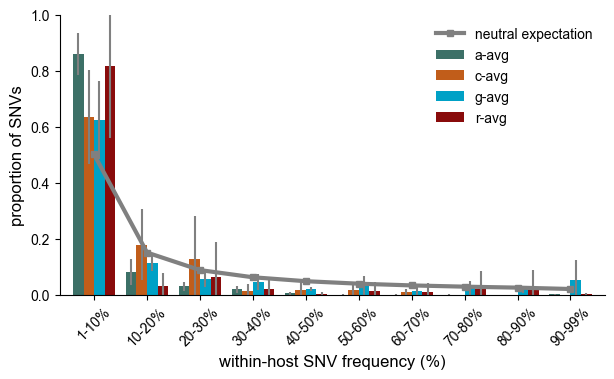

In [11]:
# plot the above dataframes 

SFS = pd.concat([anhui,CA04],axis=1)
SFS = pd.concat([SFS,GD3],axis=1)
SFS = pd.concat([SFS,rGD3],axis=1)

SFSa = SFS[['a-avg','c-avg','g-avg','r-avg']]
SFSs = SFS[['a-stdev','c-stdev','g-stdev','r-stdev']]

anhuia = anhui[['a-avg']]
anhuis = anhui[['a-stdev']]

CA04a = CA04[['c-avg']]
CA04s = CA04[['c-stdev']]

GD3a = GD3[['g-avg']]
GD3s = GD3[['g-stdev']]

rGD3a = rGD3[['r-avg']]
rGD3s = rGD3[['r-stdev']]

# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(6,6), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(2,5)

ax1 = fig.add_subplot(gs[0,0:3])

# get right of top and right frame of each subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)

# set fontsize of axes 
ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)

neutral_df.plot(kind='line', grid=False, color='grey', figsize=(12,8), alpha=1, linewidth=3, marker="s", markersize=5, ax=ax1)
SFS[['a-avg','c-avg','g-avg','r-avg']].plot(kind='bar', yerr=SFS[['a-stdev','c-stdev','g-stdev','r-stdev']].values.T, color=['#3C7067','#C15D1A','#00A1C6','#890B0B'], ecolor='grey', grid=False, figsize=(12,8), width=0.8, alpha=1, ax=ax1)

ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(0,1.0)
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax1.set_ylabel('proportion of SNVs', fontname='Arial', fontsize=12)
ax1.set_xlabel('within-host SNV frequency (%)', fontname='Arial', fontsize=12)
ax1.set_xticklabels(['1-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-99%'], fontname='Arial', fontsize=10, minor=False, rotation=45)
ax1.legend(loc=0, frameon=False, fontsize=10, ncol=1)

plt.savefig('../figures/SFS/SFS_by_virus_group.pdf', dpi=300)


In [61]:
# compare neutral distribution vs SFS for each virus subgroup 

from scipy.stats import ks_2samp
import numpy as np

#KS test 
# print(ks_2samp(CA04a['c-avg'], neutral_df['neutral expectation']))
# print(ks_2samp(anhuia['a-avg'], neutral_df['neutral expectation']))
# print(ks_2samp(GD3a['g-avg'], neutral_df['neutral expectation']))
# print(ks_2samp(rGD3a['r-avg'], neutral_df['neutral expectation']))

# Chi-square test
# print(chisquare(CA04a['c-avg'], f_exp=neutral_df['neutral expectation']))
# print(chisquare(anhuia['a-avg'], f_exp=neutral_df['neutral expectation']))
# print(chisquare(GD3a['g-avg'], f_exp=neutral_df['neutral expectation']))
# print(chisquare(rGD3a['r-avg'], f_exp=neutral_df['neutral expectation']))